In [1]:
# Import packages
%matplotlib inline
%pylab inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_score
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn_evaluation import plot

Populating the interactive namespace from numpy and matplotlib


/Users/ameenakhan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ameenakhan/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Import dataset
df = pd.read_csv('LoanStats3a.csv', header = 1, dtype={'next_pymnt_d': object, 'id': object})

# Data Wrangling

In [3]:
# Drop all empty columns and rows
df = df.dropna(axis = 1, how = 'all')
df = df.dropna(axis = 0, how = 'all')

# Drop all columns with only 158 non-null values
df = df.iloc[:, 1:58]

# Drop additional columns not of interest
df = df.iloc[:, 1:23]
df = df.drop('desc', 1) # text description of loan, not doing text analysis on this project
df = df.drop('zip_code', 1) # zip codes all end in xx
df = df.drop('delinq_2yrs', 1) # this relates to loan activity after it has been approved
df = df.drop('pymnt_plan', 1) # refers to individual who go onto payment plan after they received the loan
df = df.drop('title', 1) # redundant of purpose column 

# Identify the empty rows
nans = lambda df: df[df.isnull().all(axis=1)]
n = nans(df)

# Drop empty rows 
df = df.drop(list(n.index.values))

In [4]:
# Replace NaN in Employment Title with 'Unknown'
df['emp_title'] = df['emp_title'].fillna('Unknown')

# Replace values of < 20 with 'Other'
df = df.assign(emp_title=df.groupby('emp_title')['emp_title'].transform(lambda x: x if x.size>=25 else 'Other'))

# Calculate the mean of annual_inc
inc_mean = df['annual_inc'].mean()

# Replace all the missing values in annual_inc with the mean annual income
df['annual_inc'] = df['annual_inc'].fillna(inc_mean)

# Split issue_d into separate columns with the year and month in each column
df[['issue_year','issue_month']] = df['issue_d'].str.split('-',expand=True)

# replace the incorrect years with the correct year format 
df['issue_year'] = df['issue_year'].replace({'7': '07',
                                               '8':'08',
                                            '9':'09'})

# remove % from int_rate and convert to float 
df.int_rate = df.int_rate.replace({'\%':''}, regex = True)
df.int_rate = pd.to_numeric(df.int_rate)

In [5]:
# consolidate loan status into two catagories
df['loan_status'] = df['loan_status'].replace({'Does not meet the credit policy. Status:Fully Paid':'Fully Paid',
                                               'Does not meet the credit policy. Status:Charged Off':'Charged Off'})

# convert fully paid to 0 and charged off to 1
df['loan_status'] = df['loan_status'].replace({'Fully Paid':0,
                                               'Charged Off':1})

In [6]:
df.head()

,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,issue_year,issue_month
0,5000.0,4975.0,36 months,10.65,162.87,B,B2,Unknown,10+ years,RENT,24000.0,Verified,11-Dec,0,credit_card,AZ,27.65,11,Dec
1,2500.0,2500.0,60 months,15.27,59.83,C,C4,Other,< 1 year,RENT,30000.0,Source Verified,11-Dec,1,car,GA,1.00,11,Dec
2,2400.0,2400.0,36 months,15.96,84.33,C,C5,Unknown,10+ years,RENT,12252.0,Not Verified,11-Dec,0,small_business,IL,8.72,11,Dec
3,10000.0,10000.0,36 months,13.49,339.31,C,C1,Other,10+ years,RENT,49200.0,Source Verified,11-Dec,0,other,CA,20.00,11,Dec
4,3000.0,3000.0,60 months,12.69,67.79,B,B5,Other,1 year,RENT,80000.0,Source Verified,11-Dec,0,other,OR,17.94,11,Dec


# Exploratory Data Analysis

In [7]:
print('Number of Loans that are Fully Paid (0) or Charged Off (1):')
print(df.loan_status.value_counts())

print('Percentage of loans that are in default (1):', round(6431/(36104+6431)*100,2),'%')

Number of Loans that are Fully Paid (0) or Charged Off (1):
0    36104
1     6431
Name: loan_status, dtype: int64
Percentage of loans that are in default (1): 15.12 %


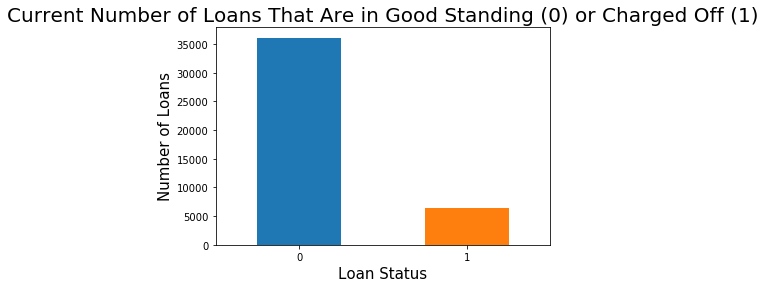

In [8]:
# Create a graph of the number of loans in either good standing or in default
df.loan_status.value_counts().plot(kind = 'bar')
plt.title('Current Number of Loans That Are in Good Standing (0) or Charged Off (1)', fontsize=20)
plt.xlabel('Loan Status', fontsize=15)
plt.ylabel('Number of Loans', fontsize=15)
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

# Machine Learning

In [14]:
# drop feature columns that should be excluded from the model 
drop = [
#    'funded_amnt', 
#    'funded_amnt_inv', 
#    'term', 
#    'int_rate', 
#    'installment', 
    'grade', 
    'sub_grade', 
    'emp_title', 
    'issue_d',
#    'emp_length', 
#    'home_ownership', 
#    'annual_inc', 
#    'verification_status', 
    'loan_status', 
    'purpose', 
    'addr_state', 
#    'dti', 
    'issue_year', 
#    'issue_month'
]

# categorical features used in the model, to be converted later
dummies = [
    'term',
#    'grade', 
#    'sub_grade', 
#    'emp_title', 
    'emp_length', 
    'home_ownership',
    'verification_status', 
#    'purpose', 
#    'addr_state',
#    'issue_year', 
    'issue_month'
]

In [15]:
# store the labels for prediction
y = df['loan_status'].values

In [16]:
print('Applications:   ', df.shape[0])
print('Dimensions:     ', df.shape[1])

Applications:    42535
Dimensions:      19


In [17]:
print('Applicants who defaulted:   ', df['loan_status'].sum(),\
      ' (', round(df['loan_status'].mean()*100,1),'%)', sep='')

Applicants who defaulted:   6431 (15.1%)


In [18]:
# drop features that will not be used in the model 
df_prep = df.drop(columns=drop)
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 11 columns):
funded_amnt            42535 non-null float64
funded_amnt_inv        42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null float64
installment            42535 non-null float64
emp_length             41423 non-null object
home_ownership         42535 non-null object
annual_inc             42535 non-null float64
verification_status    42535 non-null object
dti                    42535 non-null float64
issue_month            42535 non-null object
dtypes: float64(6), object(5)
memory usage: 3.9+ MB


In [19]:
# Create dummy columns
df_prep = pd.get_dummies(data=df_prep, columns=dummies)
df_prep.describe()

,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,term_ 36 months,term_ 60 months,emp_length_1 year,emp_length_10+ years,...,issue_month_Dec,issue_month_Feb,issue_month_Jan,issue_month_Jul,issue_month_Jun,issue_month_Mar,issue_month_May,issue_month_Nov,issue_month_Oct,issue_month_Sep
count,42535.000000,42535.000000,42535.000000,42535.000000,4.253500e+04,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,...,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000
mean,10821.585753,10139.830603,12.165016,322.623063,6.913656e+04,13.373043,0.741366,0.258634,0.084519,0.220266,...,0.110145,0.060844,0.061502,0.086846,0.082144,0.070577,0.074456,0.104361,0.098296,0.091054
std,7146.914675,7131.686447,3.707936,208.927216,6.409334e+04,6.726315,0.437889,0.437889,0.278167,0.414431,...,0.313074,0.239047,0.240252,0.281613,0.274587,0.256120,0.262515,0.305732,0.297717,0.287690
min,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.000000,4950.000000,9.630000,165.520000,4.000000e+04,8.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9600.000000,8500.000000,11.990000,277.690000,5.900000e+04,13.470000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15000.000000,14000.000000,14.720000,428.180000,8.250000e+04,18.680000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,35000.000000,35000.000000,24.590000,1305.190000,6.000000e+06,29.990000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# list feature columns remaining for creating model
feat_labels = [c for c in df_prep]

for c in feat_labels:
    print(c)

funded_amnt
funded_amnt_inv
int_rate
installment
annual_inc
dti
term_ 36 months
term_ 60 months
emp_length_1 year
emp_length_10+ years
emp_length_2 years
emp_length_3 years
emp_length_4 years
emp_length_5 years
emp_length_6 years
emp_length_7 years
emp_length_8 years
emp_length_9 years
emp_length_< 1 year
home_ownership_MORTGAGE
home_ownership_NONE
home_ownership_OTHER
home_ownership_OWN
home_ownership_RENT
verification_status_Not Verified
verification_status_Source Verified
verification_status_Verified
issue_month_Apr
issue_month_Aug
issue_month_Dec
issue_month_Feb
issue_month_Jan
issue_month_Jul
issue_month_Jun
issue_month_Mar
issue_month_May
issue_month_Nov
issue_month_Oct
issue_month_Sep


In [21]:
X = df_prep.values

In [22]:
print('Applications:   ', X.shape[0])
print('Dimensions:     ', X.shape[1])

Applications:    42535
Dimensions:      39


In [23]:
# create train and test data sets for model analysis 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
print('Test shape:   ', X_test.shape[0])
print('Dimensions:', X_test.shape[1])

Test shape:    8507
Dimensions: 39


## Test to see that you have enough data for modeling

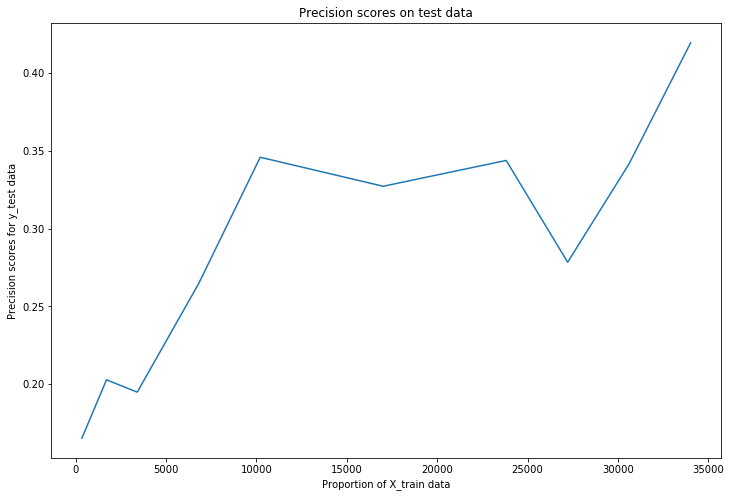

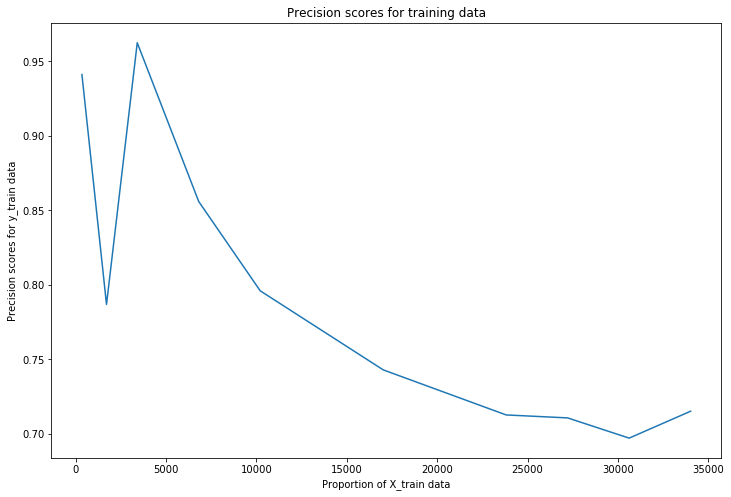

In [25]:
from sklearn.metrics import precision_score
from sklearn import tree

ps = [340, 1701, 3402, 6805, 10208, 17014, 23819, 27222, 30625, 34028]
test_scores = []
train_scores = []

for p in ps:
    X_train2 = X_train[:p]
    y_train2 = y_train[:p]
    rf2 = tree.DecisionTreeClassifier(max_depth = 7, random_state=0)
    rf2.fit(X_train2, y_train2)
    y_rf2 = rf2.predict(X_test)
    y_rf3 = rf2.predict(X_train2)
    prec_test = precision_score(y_test, y_rf2)
    prec_train = precision_score(y_train2, y_rf3)
    test_scores.append(prec_test)
    train_scores.append(prec_train)

plt.plot(ps, test_scores)
plt.xlabel('Proportion of X_train data')
plt.ylabel('Precision scores for y_test data')
plt.title('Precision scores on test data')
plt.show()

    
plt.plot(ps, train_scores)
plt.xlabel('Proportion of X_train data')
plt.ylabel('Precision scores for y_train data')
plt.title('Precision scores for training data')
plt.show()

## Random Forest

In [26]:
%%time

# run Random Forest Classifier with default parameters to get baseline 
rf = RandomForestClassifier(random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

errors = abs(y_pred - y_test)

print('Test accuracy: ', 1.0 - round(np.mean(errors), 2), sep='')

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, sample_weight=None, digits=4))

Test accuracy: 0.84
[[7076  101]
 [1262   68]]
             precision    recall  f1-score   support

          0     0.8486    0.9859    0.9121      7177
          1     0.4024    0.0511    0.0907      1330

avg / total     0.7789    0.8398    0.7837      8507

CPU times: user 720 ms, sys: 17.6 ms, total: 738 ms
Wall time: 761 ms


In [27]:
# print feature weights from model 
for feature in zip([round(elem, 2) for elem in rf.feature_importances_], feat_labels):
    print(feature)

(0.09, 'funded_amnt')
(0.12, 'funded_amnt_inv')
(0.13, 'int_rate')
(0.12, 'installment')
(0.12, 'annual_inc')
(0.13, 'dti')
(0.01, 'term_ 36 months')
(0.01, 'term_ 60 months')
(0.01, 'emp_length_1 year')
(0.01, 'emp_length_10+ years')
(0.01, 'emp_length_2 years')
(0.01, 'emp_length_3 years')
(0.01, 'emp_length_4 years')
(0.01, 'emp_length_5 years')
(0.01, 'emp_length_6 years')
(0.01, 'emp_length_7 years')
(0.01, 'emp_length_8 years')
(0.01, 'emp_length_9 years')
(0.01, 'emp_length_< 1 year')
(0.01, 'home_ownership_MORTGAGE')
(0.0, 'home_ownership_NONE')
(0.0, 'home_ownership_OTHER')
(0.01, 'home_ownership_OWN')
(0.01, 'home_ownership_RENT')
(0.01, 'verification_status_Not Verified')
(0.01, 'verification_status_Source Verified')
(0.01, 'verification_status_Verified')
(0.01, 'issue_month_Apr')
(0.01, 'issue_month_Aug')
(0.01, 'issue_month_Dec')
(0.01, 'issue_month_Feb')
(0.01, 'issue_month_Jan')
(0.01, 'issue_month_Jul')
(0.01, 'issue_month_Jun')
(0.01, 'issue_month_Mar')
(0.01, 'issue_m

In [28]:
# Create function for GridSearchCV
def fit_model(X, y):
 
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    regressor = RandomForestClassifier(class_weight='balanced', n_estimators=300)

    #  Create a dictionary for the parameters to test 
    params = { 'max_depth': [3, 5, 15, 25],
             'min_samples_split': [10, 20, 30, 50],
             'min_samples_leaf': [1, 10, 20, 30, 50],
             'n_jobs': [1, 2]}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    #  Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_, grid

def performance_metric(y_true, y_predict):
    cm = confusion_matrix(y_true, y_predict)
    score = cm[1][1]
 
    return score

In [29]:
%%time
# Run GridSearchCV on RandomForestClassifier 
best_estimator_rfc, grid_rfc = fit_model(X,y)

CPU times: user 2h 4min 47s, sys: 2min 2s, total: 2h 6min 49s
Wall time: 2h 9min 6s


In [30]:
best_estimator_rfc

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=20, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

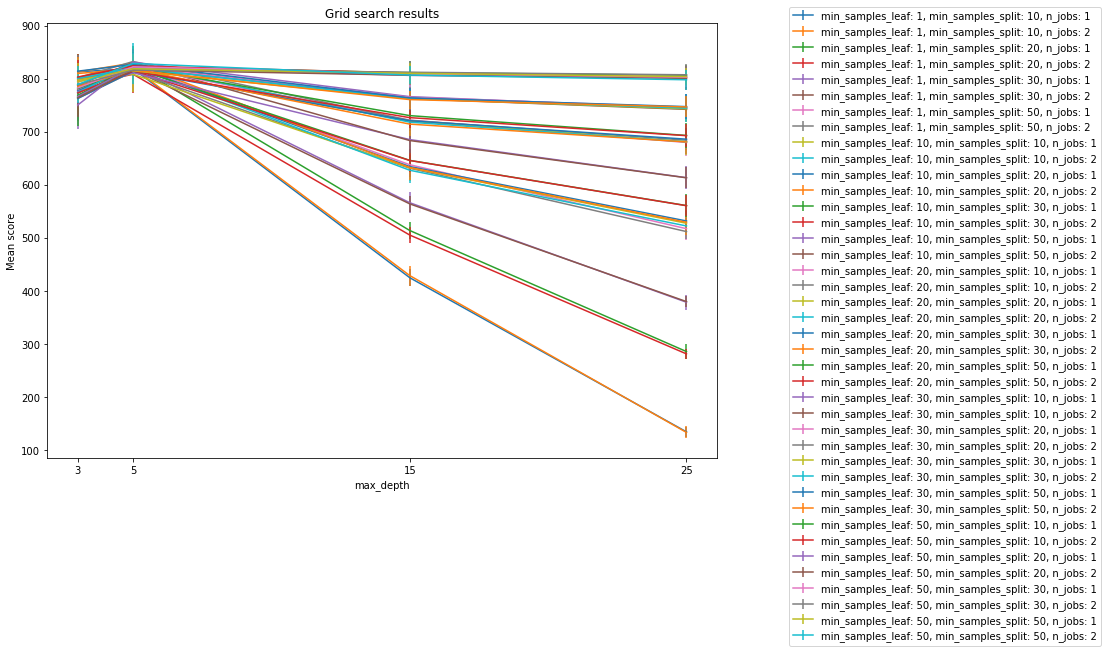

In [31]:
# plot max_depth results from GridSearchCV
plot.grid_search(grid_rfc.grid_scores_, change='max_depth', kind='line')
fig_size[0] = 12
fig_size[1] = 8
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [32]:
%%time

# run RandomForestClassifier using parameters identified in GridSearchCV codecodecodwith class weights balanced   

rf = RandomForestClassifier(class_weight='balanced',
            max_depth=25, min_samples_leaf=1, min_samples_split=10,
            n_estimators=300, n_jobs=2, random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

errors = abs(y_pred - y_test)

print('Test accuracy: ', 1.0 - round(np.mean(errors), 2), sep='')

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, sample_weight=None, digits=4))

Test accuracy: 0.83
[[6937  240]
 [1171  159]]
             precision    recall  f1-score   support

          0     0.8556    0.9666    0.9077      7177
          1     0.3985    0.1195    0.1839      1330

avg / total     0.7841    0.8341    0.7945      8507

CPU times: user 23.6 s, sys: 763 ms, total: 24.4 s
Wall time: 34.3 s


In [33]:
# model optimizing for true negatives
# run RandomForestClassifier using parameters identified in GridSearchCV with class weights balanced   

rf = RandomForestClassifier(class_weight='balanced', max_depth=5, max_features='auto',
            min_samples_leaf=1, min_samples_split=30,
            n_estimators=300, n_jobs=1,random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

errors = abs(y_pred - y_test)

print('Test accuracy: ', 1.0 - round(np.mean(errors), 2), sep='')

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, sample_weight=None, digits=4))

Test accuracy: 0.63
[[4487 2690]
 [ 492  838]]
             precision    recall  f1-score   support

          0     0.9012    0.6252    0.7382      7177
          1     0.2375    0.6301    0.3450      1330

avg / total     0.7974    0.6260    0.6768      8507



## kNN

In [34]:
# run KNeighborsClassifier using default parameters
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("kNN Accuracy: ", accuracy_score(y_test, y_pred_knn))

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, sample_weight=None, digits=4))

kNN Accuracy:  0.8268484777242271
[[6976  201]
 [1272   58]]
             precision    recall  f1-score   support

          0     0.8458    0.9720    0.9045      7177
          1     0.2239    0.0436    0.0730      1330

avg / total     0.7486    0.8268    0.7745      8507



In [37]:
# create function for performing GridSearch CV on model 
def fit_model_knn(X, y):
 
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    regressor = KNeighborsClassifier()

    #  Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'n_neighbors': [9, 15, 25, 35, 45], 'weights': ['uniform', 'distance'],
             'n_jobs': [1,2], 'leaf_size': [10, 20, 30, 40, 50]}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    #  Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_, grid

def performance_metric(y_true, y_predict):
    cm = confusion_matrix(y_true, y_predict)
    score = cm[1][1]
 
    return score

In [38]:
%%time
# run GridSearch CV on model 
best_estimator_knn, grid_knn = fit_model_knn(X, y)

CPU times: user 9min 16s, sys: 22.1 s, total: 9min 38s
Wall time: 8min 52s


In [39]:
# print best parameters from GridSearchCV
best_estimator_knn

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance')

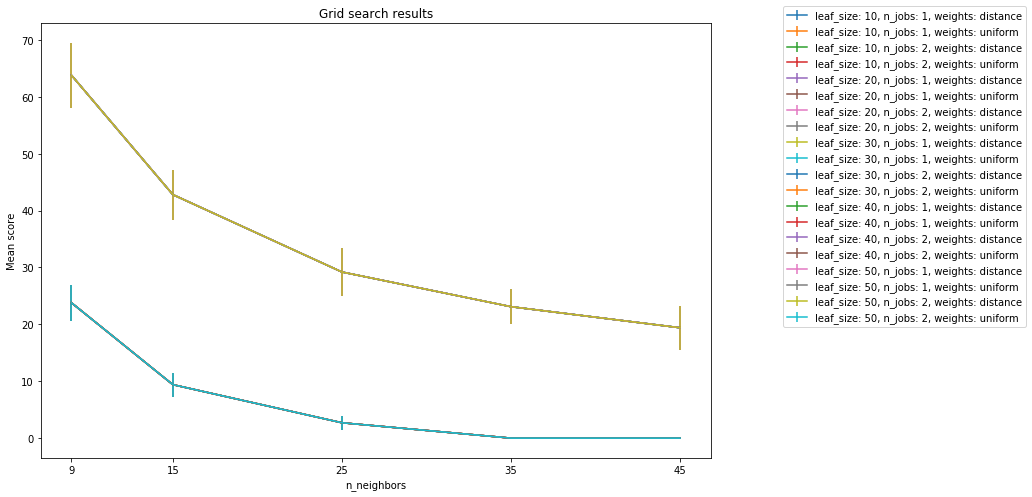

In [40]:
# Plot n_neighbors results from GridSearchCV
plot.grid_search(grid_knn.grid_scores_, change='n_neighbors', kind='line')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [41]:
# run KNeighborsClassifier using results from GridSearchCV optimizing for precision
knn = KNeighborsClassifier(n_neighbors=25, leaf_size=10, weights='uniform')

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("kNN Accuracy: ", accuracy_score(y_test, y_pred_knn))

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, sample_weight=None, digits=4))

kNN Accuracy:  0.8441283648759845
[[7176    1]
 [1325    5]]
             precision    recall  f1-score   support

          0     0.8441    0.9999    0.9154      7177
          1     0.8333    0.0038    0.0075      1330

avg / total     0.8424    0.8441    0.7735      8507



In [42]:
# run KNeighborsClassifier using results from GridSearchCV optimizing for True Negatives
knn = KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance')

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("kNN Accuracy: ", accuracy_score(y_test, y_pred_knn))

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, sample_weight=None, digits=4))

kNN Accuracy:  0.8202656635711767
[[6910  267]
 [1262   68]]
             precision    recall  f1-score   support

          0     0.8456    0.9628    0.9004      7177
          1     0.2030    0.0511    0.0817      1330

avg / total     0.7451    0.8203    0.7724      8507



## Additional Code Not Used In Final Report
Below is additional code I ran to perform some statistical analysis and explore the data that did not end up in my final report. 

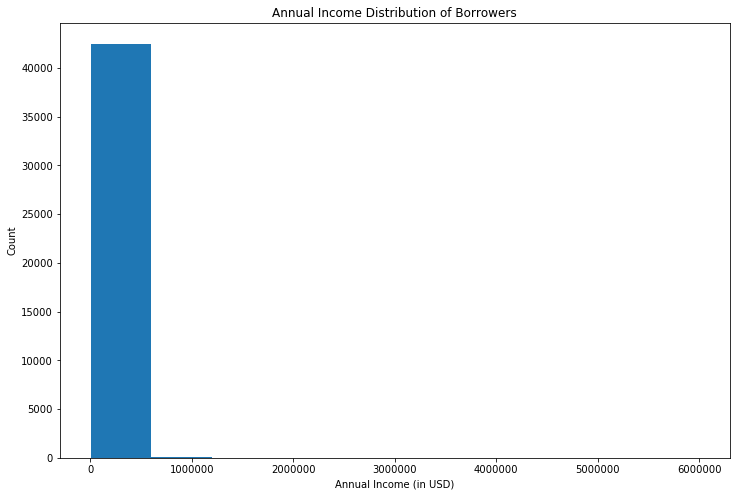

In [43]:
# Plot annual income distribution of borrowers
plt.hist(df.annual_inc)
plt.title('Annual Income Distribution of Borrowers')
plt.xlabel('Annual Income (in USD)')
plt.ylabel('Count')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

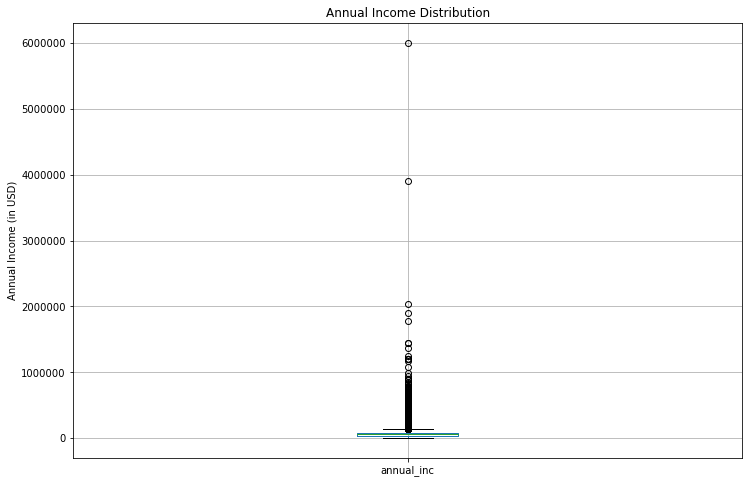

In [44]:
# Create a boxplot of annual_inc
df.boxplot(column=['annual_inc'])
plt.title('Annual Income Distribution')
plt.ylabel('Annual Income (in USD)')

,mean,std
loan_status,,
0,70164.277724,66280.247602
1,63366.870530,49684.103432


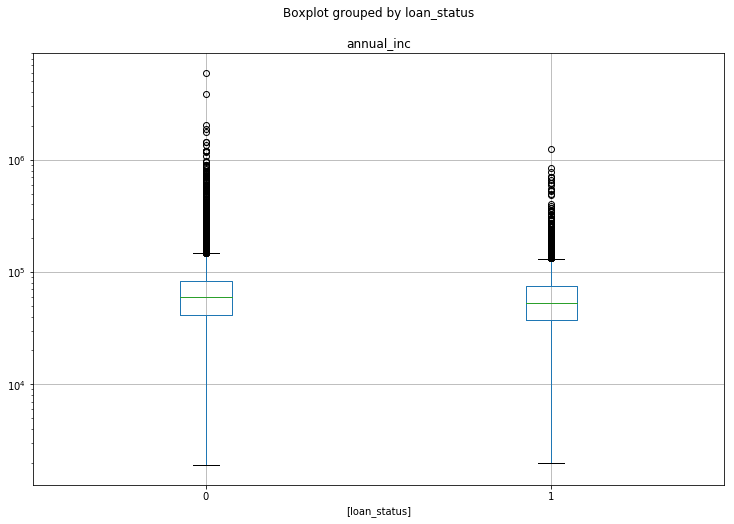

In [45]:
# Compare income to loan status 
df.boxplot(column=['annual_inc'],by = ['loan_status']).set_yscale('log')
pd.DataFrame(df.groupby( ['loan_status'])['annual_inc'].describe().loc[:,['mean','std']])

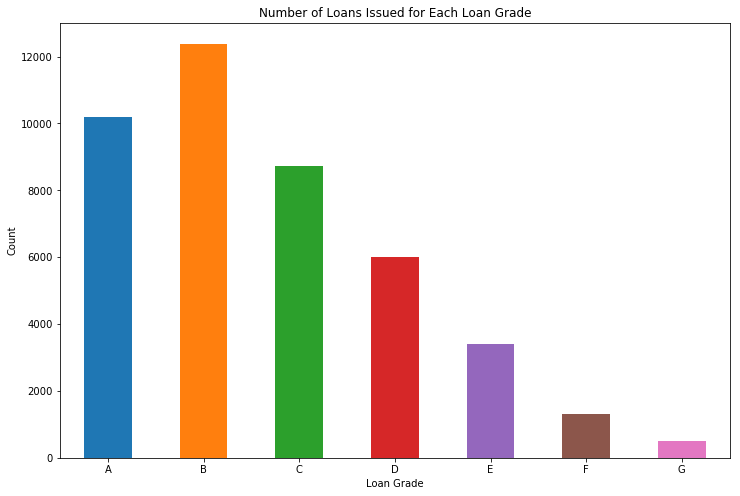

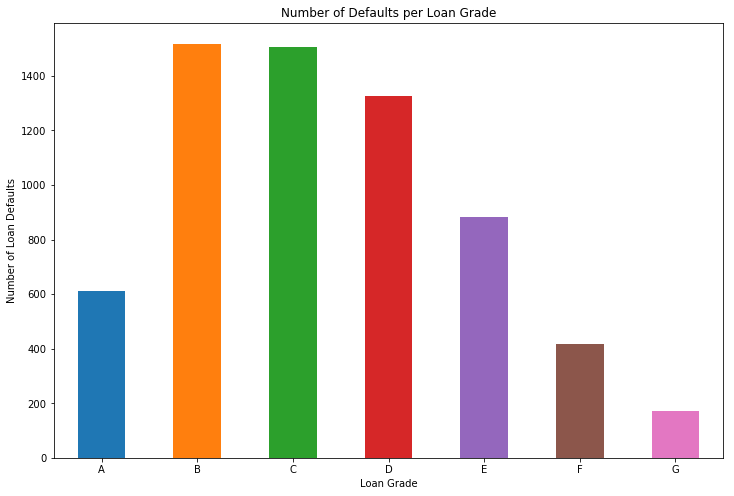

,loan_status
grade,
A,0.059904
B,0.122528
C,0.172082
D,0.220578
E,0.260165
F,0.319754
G,0.337891


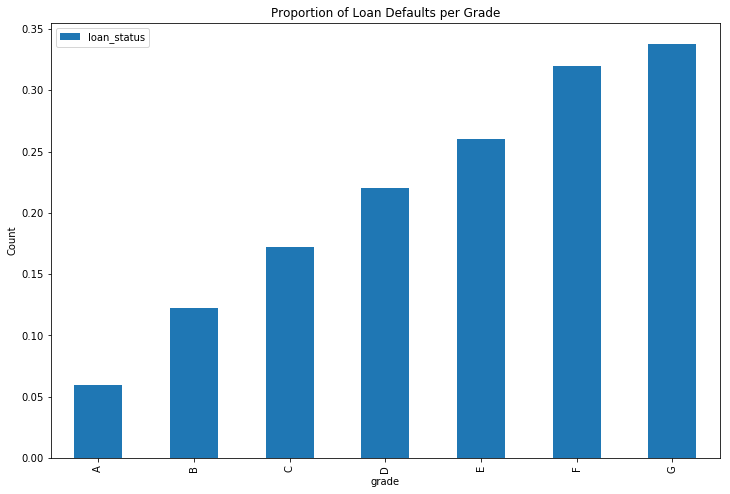

In [46]:
# Create a bar graph that counts the number of loans issued in each grade
df.grade.value_counts().sort_index().plot(kind = 'bar')
plt.title('Number of Loans Issued for Each Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

# Create a bar plot that shows how many loans defaulted in each grade
ab = df
ab = df[df.loan_status == 1]
ab.grade.value_counts().sort_index().plot(kind = 'bar')
plt.title('Number of Defaults per Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Number of Loan Defaults')
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

# Create a proportion chart to show the proportion of loans that default in each grade
df.groupby(['grade'])[['loan_status']].mean().plot(kind='bar').set_ylabel('Count')
plt.title('Proportion of Loan Defaults per Grade')
df.groupby(['grade' ])[['loan_status']].mean()

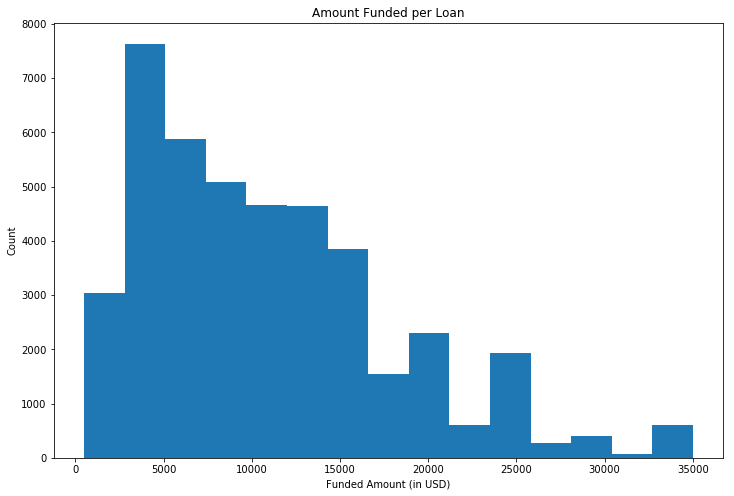

In [47]:
# Create a histogram of funded_amnt
plt.hist(df.funded_amnt, 15)
plt.title('Amount Funded per Loan')
plt.xlabel('Funded Amount (in USD)')
plt.ylabel('Count')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

,funded_amnt
loan_status,
0,10702.134805
1,11492.190173


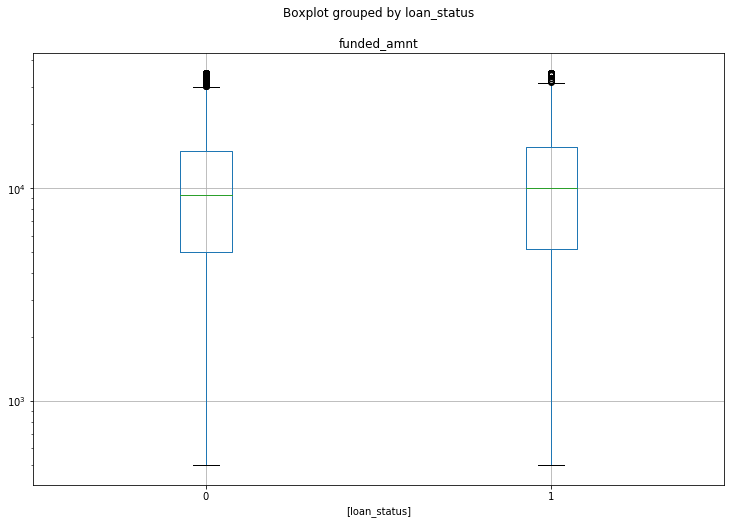

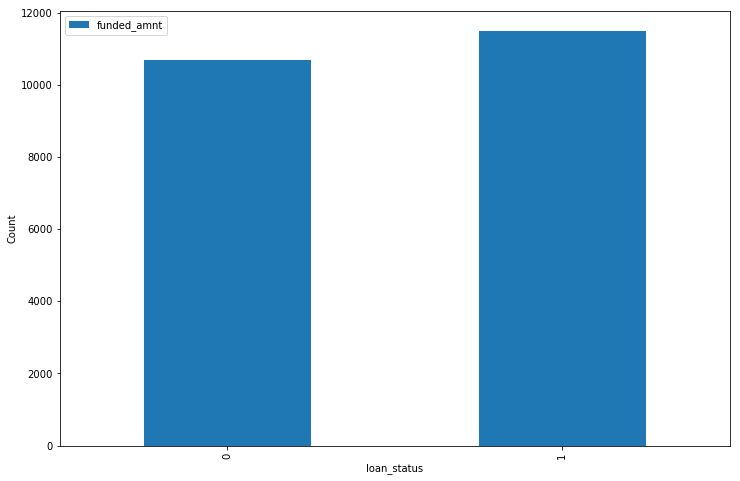

In [48]:
# Create box plot of funded_amnt and loan_status
df.boxplot(column=['funded_amnt'],by = ['loan_status']).set_yscale('log')
pd.DataFrame(df.groupby( ['loan_status'])['funded_amnt'].describe().loc[:,['mean','std']])

# Compare the ratio for funded_amnt and loan_status
df.groupby(['loan_status'])[['funded_amnt']].mean().plot(kind='bar').set_ylabel('Count')
df.groupby(['loan_status' ])[['funded_amnt']].mean()

In [50]:
from scipy import stats

#Perform a t-test on funded_amnt
val1 = df.funded_amnt[df.loan_status == 0]
val2 = df.funded_amnt[df.loan_status == 1]
stats.ttest_ind(val1, val2)

Ttest_indResult(statistic=-8.173693365124826, pvalue=3.072709571040925e-16)

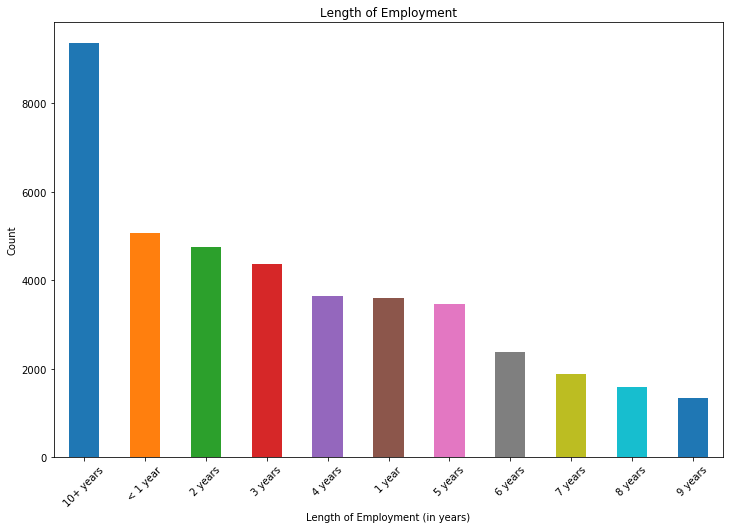

In [51]:
# Graph distribution of employment length
df.emp_length.value_counts().plot(kind = 'bar')
plt.title('Length of Employment')
plt.xlabel('Length of Employment (in years)')
plt.ylabel('Count')
plt.xticks(rotation='45')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
import statsmodels.api as smplt.show()

In [53]:
import statsmodels.api as sm

# Perform logistic regression
df_ind = pd.get_dummies(df['emp_length'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df.loan_status

logit = sm.Logit(df_ind['loan_status'], df_ind [['1 year','10+ years','2 years','3 years','4 years','5 years',
                                                 '6 years','7 years','8 years','9 years','< 1 year', 'intercept']] )

result = logit.fit() 

result.summary()

/Users/ameenakhan/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.424087
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42523
Method:                           MLE   Df Model:                           11
Date:                Tue, 04 Sep 2018   Pseudo R-squ.:                0.001616
Time:                        19:59:22   Log-Likelihood:                -18039.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                 1.830e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1 year        -0.4454      0.086     -5.185      0.000      -0.614      -0.277
10+ years     -0.3905      0.078     -5.030      0.000      -0.543      -0.238
2 years       -0.5692      0.084     -6.799      0.000      -0.733      -0.405
3 years       -0.5157      0.084     -6.125      0.000      -0.681      -0.351
4 years       -0.5264      0.086     -6.090      0.000      -0.696      -0.357
5 years       -0.4930      0.087     -5.678      0.000      -0.663      -0.323
6 years       -0.4849      0.093     -5.238      0.000      -0.666      -0.303
7 years       -0.4144      0.096     -4.307      0.000      -0.603      -0.226
8 years       -0.4748      0.101     -4.707      0.000      -0.672      -0.277
9 years       -0.6003      0.108     -5.561      0.000      -0.812      -0.389
< 1 year      -0.4837      0.082     -5.867      0.000      -0.645      -0.322
intercept     -1.2638      0.072    -17.467      0.000      -1.406      -1.122
==============================================================================
"""

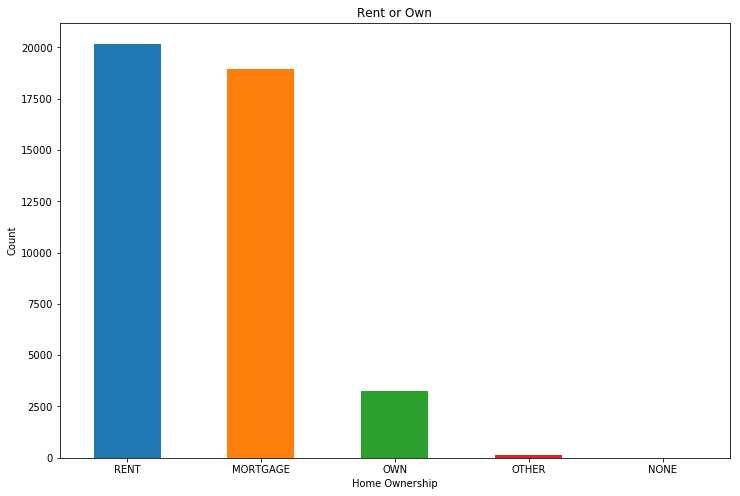

In [54]:
# Graph distribution of home ownership
df.home_ownership.value_counts().plot(kind = 'bar')
plt.title('Rent or Own')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

In [55]:
# Perform logistic regression
df_ind = pd.get_dummies(df['home_ownership'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df.loan_status

logit = sm.Logit(df_ind['loan_status'], df_ind [['MORTGAGE', 'OTHER', 'OWN', 'RENT', 'intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.424482
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42530
Method:                           MLE   Df Model:                            4
Date:                Tue, 04 Sep 2018   Pseudo R-squ.:               0.0006844
Time:                        19:59:23   Log-Likelihood:                -18055.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                 5.695e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MORTGAGE       0.1501      1.069      0.140      0.888      -1.946       2.246
OTHER          0.6404      1.089      0.588      0.557      -1.495       2.775
OWN            0.2289      1.070      0.214      0.831      -1.869       2.326
RENT           0.2796      1.069      0.261      0.794      -1.816       2.375
intercept     -1.9459      1.069     -1.820      0.069      -4.041       0.149
==============================================================================
"""

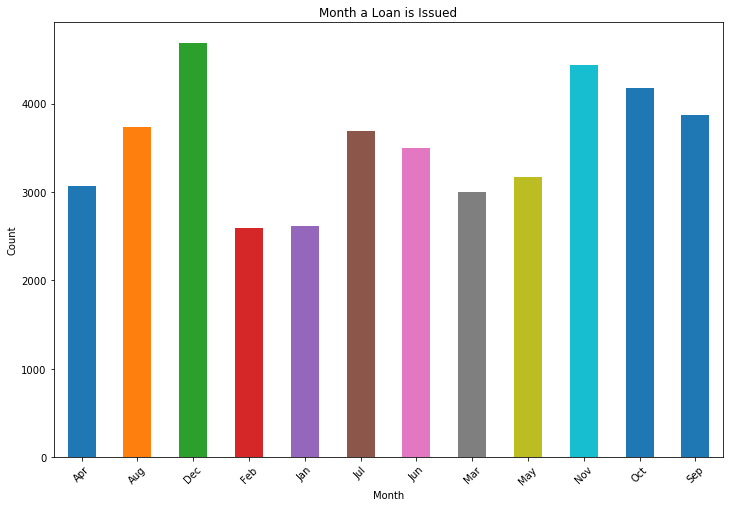

In [56]:
# Count number of loans given in each month
df.issue_month.value_counts().sort_index().plot(kind = 'bar')
plt.title('Month a Loan is Issued')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation='45')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

In [57]:
# Perform logistic regression
df_ind = pd.get_dummies(df['issue_month'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df.loan_status

logit = sm.Logit(df_ind['loan_status'], df_ind [['Aug', 'Dec',  'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 
                                                 'Nov', 'Oct', 'Sep','intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.424498
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42523
Method:                           MLE   Df Model:                           11
Date:                Tue, 04 Sep 2018   Pseudo R-squ.:               0.0006478
Time:                        19:59:26   Log-Likelihood:                -18056.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                   0.01547
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Aug           -0.0086      0.070     -0.123      0.902      -0.146       0.129
Dec            0.1426      0.065      2.183      0.029       0.015       0.271
Feb           -0.0685      0.078     -0.884      0.377      -0.221       0.083
Jan            0.0970      0.075      1.295      0.195      -0.050       0.244
Jul            0.0266      0.070      0.381      0.703      -0.110       0.163
Jun            0.1225      0.070      1.762      0.078      -0.014       0.259
Mar            0.0033      0.074      0.045      0.964      -0.141       0.147
May            0.1496      0.071      2.112      0.035       0.011       0.288
Nov            0.1059      0.066      1.597      0.110      -0.024       0.236
Oct            0.1205      0.067      1.799      0.072      -0.011       0.252
Sep            0.1095      0.068      1.607      0.108      -0.024       0.243
intercept     -1.8002      0.052    -34.781      0.000      -1.902      -1.699
==============================================================================
"""

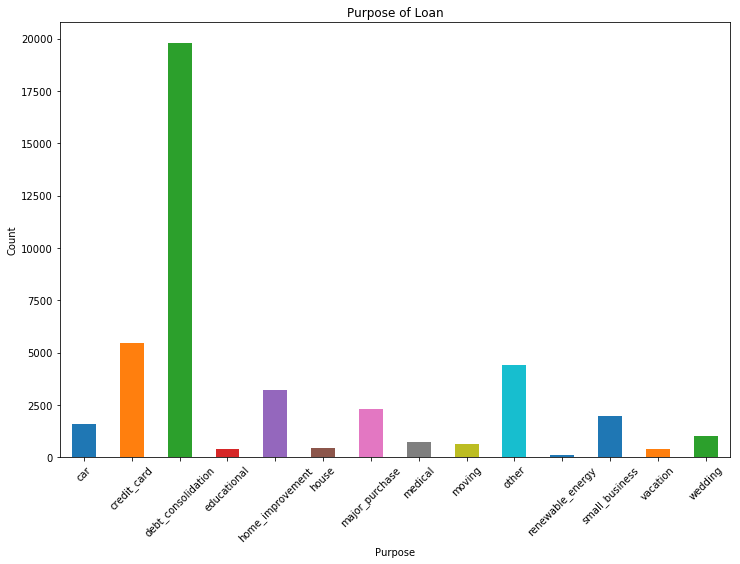

In [58]:
# Create a graph to count the number of each loan purpose
df.purpose.value_counts().sort_index().plot(kind = 'bar')
plt.title('Purpose of Loan')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.xticks(rotation='45')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

In [59]:
# Perform logistic regression
df_ind = pd.get_dummies(df['purpose'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df['loan_status'] 

df_ind= df_ind.fillna(0) 

logit = sm.Logit(df_ind['loan_status'], df_ind [['credit_card', 'debt_consolidation',  'educational', 
                                                  'home_improvement',  'house',  'major_purchase',  'medical', 
                                                  'moving',  'other',  'renewable_energy', 'small_business', 'vacation',
                                                 'wedding', 'intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.420097
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42521
Method:                           MLE   Df Model:                           13
Date:                Tue, 04 Sep 2018   Pseudo R-squ.:                 0.01101
Time:                        19:59:27   Log-Likelihood:                -17869.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                 6.579e-77
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
credit_card            0.0566      0.091      0.621      0.535      -0.122       0.235
debt_consolidation     0.4318      0.083      5.214      0.000       0.269       0.594
educational            0.7867      0.144      5.451      0.000       0.504       1.070
home_improvement       0.2364      0.096      2.464      0.014       0.048       0.424
house                  0.4941      0.154      3.218      0.001       0.193       0.795
major_purchase        -0.0116      0.105     -0.111      0.912      -0.218       0.194
medical                0.5348      0.126      4.243      0.000       0.288       0.782
moving                 0.5357      0.133      4.022      0.000       0.275       0.797
other                  0.5440      0.090      6.058      0.000       0.368       0.720
renewable_energy       0.6619      0.261      2.536      0.011       0.150       1.173
small_business         1.1591      0.095     12.230      0.000       0.973       1.345
vacation               0.3661      0.162      2.255      0.024       0.048       0.684
wedding                0.0150      0.129      0.116      0.908      -0.239       0.269
intercept             -2.1205      0.080    -26.355      0.000      -2.278      -1.963
======================================================================================
"""

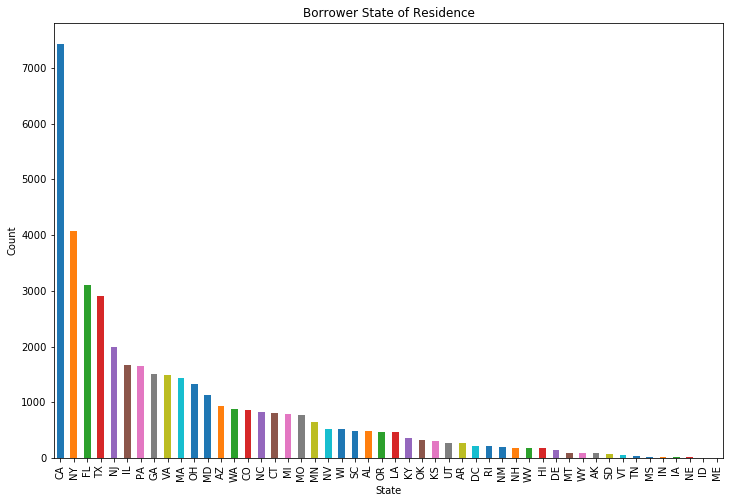

In [60]:
# Create a graph to visualize the distribution of loans per state
df.addr_state.value_counts().plot(kind = 'bar')
plt.title('Borrower State of Residence')
plt.xlabel('State')
plt.ylabel('Count')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

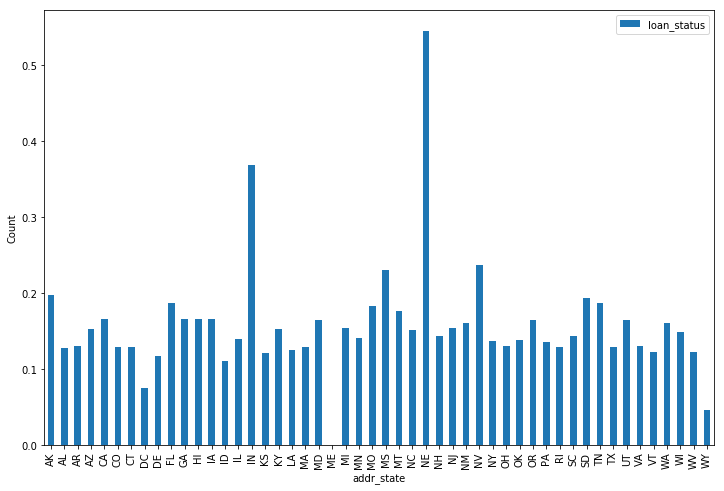

In [61]:
# Create a graph for the proportion of loans that default in each state
df.groupby(['addr_state'])[['loan_status']].mean().plot(kind='bar').set_ylabel('Count')

In [62]:
# Perform logistic Regression
df_ind = pd.get_dummies(df['addr_state'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df['loan_status'] 

df_ind= df_ind.fillna(0) 

logit = sm.Logit(df_ind['loan_status'], df_ind [['AL','AR','AZ','CA','CO','CT','DC','DE','FL','GA','HI','IA','ID',
                                                 'IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO','MS','MT','NC','NE',
                                                 'NH','NJ','NM','NV','NY','OH','OK','OR','PA','RI','SC','SD','TN','TX',
                                                 'UT','VA','VT','WA','WI','WV','WY','intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.422669
         Iterations 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42485
Method:                           MLE   Df Model:                           49
Date:                Tue, 04 Sep 2018   Pseudo R-squ.:                0.004953
Time:                        19:59:32   Log-Likelihood:                -17978.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                 1.070e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AL            -0.5170      0.303     -1.706      0.088      -1.111       0.077
AR            -0.4977      0.327     -1.521      0.128      -1.139       0.144
AZ            -0.3083      0.286     -1.079      0.280      -0.868       0.251
CA            -0.2145      0.273     -0.787      0.431      -0.749       0.320
CO            -0.5043      0.289     -1.743      0.081      -1.071       0.063
CT            -0.5009      0.290     -1.727      0.084      -1.070       0.068
DC            -1.0986      0.370     -2.968      0.003      -1.824      -0.373
DE            -0.6140      0.380     -1.617      0.106      -1.358       0.130
FL            -0.0676      0.275     -0.246      0.806      -0.606       0.471
GA            -0.2109      0.279     -0.755      0.450      -0.759       0.337
HI            -0.2152      0.337     -0.639      0.523      -0.875       0.444
IA            -0.2085      0.821     -0.254      0.799      -1.817       1.400
ID            -0.6785      1.095     -0.620      0.535      -2.824       1.467
IL            -0.4148      0.280     -1.482      0.138      -0.963       0.134
IN             0.8619      0.547      1.575      0.115      -0.211       1.935
KS            -0.5839      0.324     -1.803      0.071      -1.219       0.051
KY            -0.3088      0.308     -1.003      0.316      -0.912       0.295
LA            -0.5376      0.305     -1.762      0.078      -1.135       0.060
MA            -0.5120      0.282     -1.816      0.069      -1.065       0.041
MD            -0.2182      0.282     -0.773      0.440      -0.772       0.335
ME          -126.0556   2.74e+27   -4.6e-26      1.000   -5.38e+27    5.38e+27
MI            -0.2987      0.288     -1.037      0.300      -0.863       0.266
MN            -0.4053      0.293     -1.382      0.167      -0.980       0.169
MO            -0.0952      0.286     -0.332      0.740      -0.657       0.466
MS             0.1969      0.539      0.366      0.715      -0.859       1.252
MT            -0.1353      0.381     -0.356      0.722      -0.881       0.610
NC            -0.3196      0.288     -1.112      0.266      -0.883       0.244
NE             1.5832      0.663      2.387      0.017       0.283       2.883
NH            -0.3847      0.341     -1.127      0.260      -1.054       0.284
NJ            -0.2956      0.278     -1.064      0.287      -0.840       0.249
NM            -0.2501      0.331     -0.756      0.450      -0.898       0.398
NV             0.2328      0.289      0.804      0.421      -0.335       0.800
NY            -0.4373      0.275     -1.592      0.111      -0.975       0.101
OH            -0.4919      0.283     -1.740      0.082      -1.046       0.062
OK            -0.4244      0.316     -1.344      0.179      -1.043       0.194
OR            -0.2240      0.298     -0.751      0.452      -0.808       0.360
PA            -0.4456      0.280     -1.591      0.112      -0.995       0.103
RI            -0.5018      0.340     -1.474      0.140      -1.169       0.165
SC

,mean,std
loan_status,,
0,13.253252,6.731947
1,14.045559,6.655208


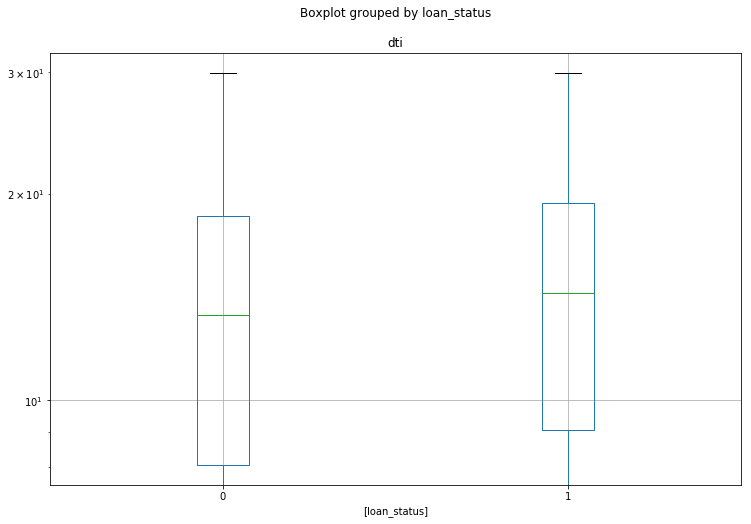

In [63]:
# Create a box plot to visualize the difference between loan status
df.boxplot(column=['dti'],by = ['loan_status']).set_yscale('log')
pd.DataFrame(df.groupby( ['loan_status'])['dti'].describe().loc[:,['mean','std']])

In [64]:
# Perform t-test
val1 = df.dti[df.loan_status == 0]
val2 = df.dti[df.loan_status == 1]
stats.ttest_ind(val1, val2)

Ttest_indResult(statistic=-8.710479487785241, pvalue=3.1327064696533274e-18)